In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from scipy import stats, interp
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict,StratifiedKFold
from sklearn.svm import SVC, LinearSVC # "Support vector classifier"
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import grid_search
from sklearn.metrics import classification_report,accuracy_score, log_loss, roc_curve, auc,confusion_matrix
from itertools import cycle
import itertools
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import RFECV
%matplotlib inline


In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
df.info()

In [ ]:
df.head()
# print("Gender: ", df.gender.unique())
# print("Partner: ", df.Partner.unique())
# print("Dependents: ", df.Dependents.unique())
# print("PhoneService: ", df.PhoneService.unique())
# print("MultipleLines: ", df.MultipleLines.unique())
# print("InternetService: ", df.InternetService.unique())
# print("OnlineSecurity: ", df.OnlineSecurity.unique())
# print("OnlineBackup: ", df.OnlineBackup.unique())
# print("DeviceProtection: ", df.DeviceProtection.unique())
# print("TechSupport: ", df.TechSupport.unique())
# print("StreamingTV: ", df.StreamingTV.unique())
# print("StreamingMovies: ", df.StreamingMovies.unique())
# print("Contract: ", df.Contract.unique())
# print("PaperlessBilling: ", df.PaperlessBilling.unique())
# print("PaymentMethod: ", df.PaymentMethod.unique())
# #print("TotalCharges: ", df.TotalCharges.unique())
# print("Churn: ", df.Churn.unique())
# #churn is target

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
df.describe()
# missing TotalCharges for 9 customers
# could drop or use mean TotalCharges -> replace with 0 because they are new customers 

In [7]:
print(df[['tenure', 'MonthlyCharges','TotalCharges','Contract']].head())

df[df.isnull().any(axis=1)]["tenure"]

# the people missing totalCharges values did not churn
# customers who have TotalCharges of 0 have also not finished a contract yet but do have monthlycharges data
# in row 1 you can see that they have only been a customer for one month
# 1889.50/56.95 = approx 33
# tenure is number of months they have been a customer


   tenure  MonthlyCharges  TotalCharges        Contract
0       1           29.85         29.85  Month-to-month
1      34           56.95       1889.50        One year
2       2           53.85        108.15  Month-to-month
3      45           42.30       1840.75        One year
4       2           70.70        151.65  Month-to-month


488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

In [8]:
df.TotalCharges = df.TotalCharges.fillna(0)

In [9]:
# enumerating categorical columns
categorical_columns = list(df.select_dtypes(exclude=np.number).columns)[1:]
for cat in categorical_columns:
    if len(df[cat].unique()) < 3:
        categorical_columns.remove(cat)
        if df[cat].str.contains('Yes').any():
            df[cat] = df[cat].eq('Yes').mul(1)

In [10]:
categorical_columns.remove('Partner')
# categorical columns with more than two possible values
df = pd.get_dummies(df, columns=categorical_columns)
df.gender = df.gender.eq('Female').mul(1)
df.Partner = df.Partner.eq('Yes').mul(1)

In [11]:
df.to_csv('churned_cleaned.csv')

In [12]:
df.info()
tograph = ["tenure","MonthlyCharges","TotalCharges"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 43 columns):
customerID                                 7043 non-null object
gender                                     7043 non-null int32
SeniorCitizen                              7043 non-null int64
Partner                                    7043 non-null int32
Dependents                                 7043 non-null int32
tenure                                     7043 non-null int64
PaperlessBilling                           7043 non-null int32
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
Churn                                      7043 non-null int32
PhoneService_No                            7043 non-null uint8
PhoneService_Yes                           7043 non-null uint8
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
Multip

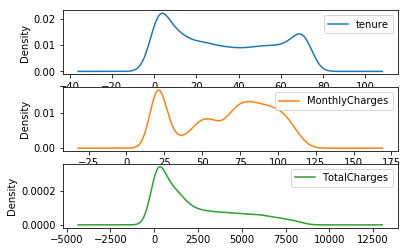

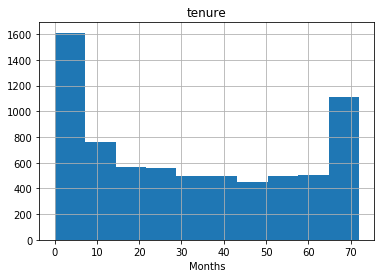

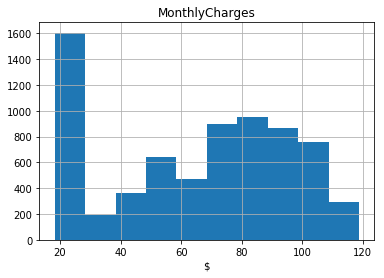

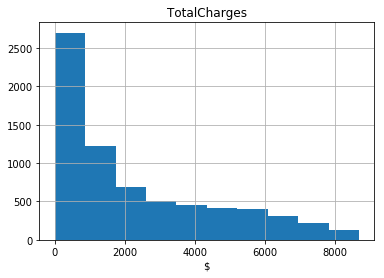

In [13]:
# # normality test
# stat, p = stats.shapiro(df['MonthlyCharges'])
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
#     print('Sample looks Gaussian (fail to reject H0)')
# else:
#     print('Sample does not look Gaussian (reject H0)')
# data.hist()
# plt.show()
data = df[tograph]
data.plot(kind='density', subplots=True,  sharex=False)
plt.show()
df['tenure'].hist()
plt.title("tenure")
plt.xlabel("Months")
plt.show()
df['MonthlyCharges'].hist()
plt.title("MonthlyCharges")
plt.xlabel("$")
plt.show()
df['TotalCharges'].hist()
plt.title("TotalCharges")
plt.xlabel("$")
plt.show()

In [14]:
#check how many of each churn class
print("Churned: ", len(df[df["Churn"] == 1]))
print("Stayed: ", len(df[df["Churn"] == 0]))

Churned:  1869
Stayed:  5174


In [15]:
df_description = df.describe()
df_description[['tenure','MonthlyCharges','TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


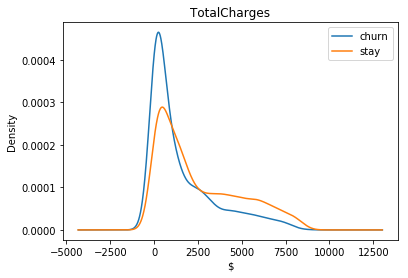

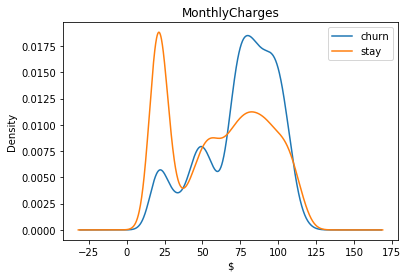

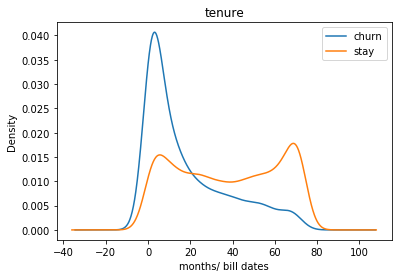

In [16]:
df_churn = df[df["Churn"]==1]
df_stay = df[df["Churn"]==0]
df_churn['TotalCharges'].plot(kind='density',label="churn")
df_stay['TotalCharges'].plot(kind='density',label="stay")
plt.title("TotalCharges")
plt.xlabel("$")
plt.legend()
plt.show()
df_churn['MonthlyCharges'].plot(kind='density',label="churn")
df_stay['MonthlyCharges'].plot(kind='density',label="stay")
plt.title("MonthlyCharges")
plt.xlabel("$")
plt.legend()
plt.show()
df_churn['tenure'].plot(kind='density',label="churn")
df_stay['tenure'].plot(kind='density',label="stay")
plt.title("tenure")
plt.xlabel("months/ bill dates")
plt.legend()
plt.show()

--------

In [76]:
# not including churn or customer id
df["extra_fees"] = df.apply((lambda x: x.TotalCharges - (x.tenure*x.MonthlyCharges)),axis=1)
X = df[df.columns.difference(['Churn', 'customerID'])].values
y = df["Churn"].values
print("FULL")
print(X.shape)
print(y.shape)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X Train: ", X_train.shape)
print("y Train: ",y_test.shape)
print("X Test: ",X_test.shape)
print("y Test: ",y_test.shape)

FULL
(7043, 42)
(7043,)
X Train:  (5634, 42)
y Train:  (1409,)
X Test:  (1409, 42)
y Test:  (1409,)


--------

### Baseline

In [ ]:
# model = SVC(kernel="linear",C=0.1,gamma=0.001)
# #model = SVC(kernel="rbf",C=10,gamma=0.01)
# #model = SVC(kernel="poly",degree=2,C=10)
baseline_model = SVC()
y_pred = cross_val_predict(baseline_model, X, y, cv=5)

In [ ]:
#http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#support-vector-machines-svmsy_pred = baseline_model.predict(X_test)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

#### Baseline with standardization

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
baseline_model_scale = SVC()
y_pred = cross_val_predict(baseline_model_scale, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

In [85]:
def svc_param_selection(X, y, nfolds, k):
    #C = 2−5, 2−3, . . . , 215 and γ = 2−15, 2−13, . . . , 23.
    Cs = [2**-5,2**-3,2**-1,2,2**3,2**5,2**7,2**9,2**11,2**13,2**15]

    #Cs = [0.001, 0.01, 0.1, 1, 10, 5,0.5,0.05]
    #gammas = [0.001, 0.01, 0.1, 1,10]
    gammas = [2**-15,2**-13,2**-11,2**-9,2**-7,2**-5,2**-3,2**-1,2,2**2]
    param_grid = {'C': Cs,'gamma':gammas}
    if k == "poly":
        #degrees = [1,2,3,2**-7,2**-5,2**-3,2**-1,2,2**24]
        param_grid['degree'] = degrees
    
    grid_search = GridSearchCV(SVC(kernel=k), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
#using already regularized training data
opt_params_linear = svc_param_selection(X, y, 5, 'linear')
print(opt_params_linear)
opt_params_rbf = svc_param_selection(X, y, 5, 'rbf')
print(opt_params_rbf)

In [ ]:
%time opt_params_poly = svc_param_selection(X_train, y_train, 5, 'poly')
#opt_params_poly = {'degree':2, 'C':10}

#### linear kernel with params

In [ ]:
linear_model = SVC(kernel="linear", C=0.01, gamma=0.001)
y_pred = cross_val_predict(linear_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_name = list(df.columns)
features_name.remove('Churn')
features_name.remove('customerID')
model = SVC(kernel="linear", C=0.01, gamma=0.001)
model.fit(X,y)
print(model.coef_)
f_importances(model.coef_[0], features_name)

#### rbf kernel with params

In [ ]:
rbf_model = SVC(kernel="rbf", C=10, gamma=0.001)
y_pred = cross_val_predict(rbf_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

#### polynomial kernel with params

In [ ]:
polynomial_model = SVC(kernel="poly", degree=2, C=10)
y_pred = cross_val_predict(polynomial_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

#### FINAL 

In [ ]:
# new column for extra fees
df["extra_fees"] = df.apply((lambda x: x.TotalCharges - (x.tenure*x.MonthlyCharges)),axis=1)

In [ ]:
X = df_new[df_new.columns.difference(['Churn', 'customerID'])].values
y = df_new["Churn"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
final_model = SVC(kernel="rbf", C=10, gamma=0.001)
y_pred = cross_val_predict(final_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

In [ ]:
cm = confusion_matrix(y_pred, y)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Stayed','Churned']
plt.title('SVM RBF Kernel Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TP','FP'], ['FN', 'TN']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

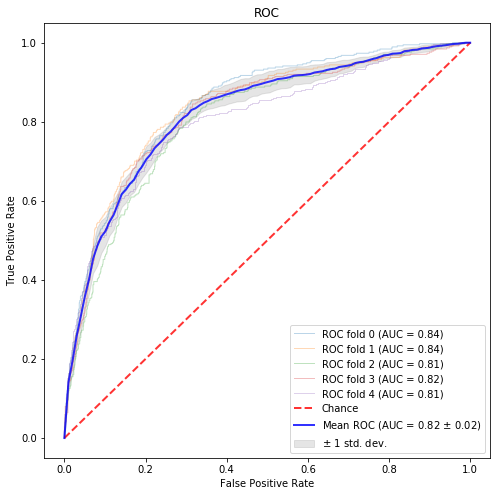

In [91]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = SVC(kernel="rbf",C=8, gamma=0.001953125, probability=True,random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df_missed  = df.iloc[np.where(y_pred != y)[0]]

In [ ]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
to_drop

In [ ]:
df_new = df.drop(to_drop,axis=1)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['Churn']]], axis = 1)

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colours = ['r', 'y']
for target, colour in zip(targets,colours):
    indicesToKeep = finalDf['Churn'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = colour
               ,  alpha=0.3,label=str(target))
for i in range(principalDf.shape[0]):
    if i%50==0:
        ax.text(finalDf.loc[i, 'principal component 1']
               , finalDf.loc[i, 'principal component 2'], round(df.loc[i,'PhoneService_No'],2))
ax.legend(targets)
ax.grid()

In [ ]:
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df[['Churn']]], axis = 1)

In [ ]:
cols = finalDf[['principal component 1','principal component 2','principal component 3']].values


In [ ]:
cols.shape

In [ ]:
baseline_model = SVC()
y_pred = cross_val_predict(baseline_model, cols, y, cv=5)
print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

In [ ]:
fig = plt.figure(1, figsize=(11, 11))
plt.clf()
ax = Axes3D(fig)
targets=[0,1]

# for i in range(0,X.shape[0]):
#     ax.text3D(cols[i, 0], cols[i, 1],cols[i, 2], "  "+str(i),fontsize='x-small')
# Reorder the labels to have colors matching the cluster results


# ax.scatter(cols[:, 0], cols[:, 1], cols[:, 2],c=y)
targets = [0,1]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = finalDf['Churn'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
            ,finalDf.loc[indicesToKeep, 'principal component 3']
               , c = colour
               ,  alpha=0.3,label=str(target))

for i in range(cols.shape[0]):
    if i%30==0:
        ax.text(finalDf.loc[i, 'principal component 1']
               , finalDf.loc[i, 'principal component 2']
            ,finalDf.loc[i, 'principal component 3'], round(df.loc[i,'PhoneService_No'],2))
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlabel('X axis')
plt.legend(targets)
ax.set_title('3 component PCA', fontsize = 20)

plt.show()

In [ ]:
np.isnan(np.min(cols))

In [ ]:
#using already regularized training data
opt_params_linear = svc_param_selection(cols, y, 3, 'linear')
print(opt_params_linear)
opt_params_rbf = svc_param_selection(cols, y, 3, 'rbf')
print(opt_params_rbf)

In [ ]:
#%time opt_params_poly = svc_param_selection(cols, y, 5, 'poly')
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
#Applying PCA here
pca = PCA(n_components= None) #We will set it none so that we can see the variance explained and then choose no of comp.
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
explained_variance

In [ ]:
baseline_model = SVC(kernel="rbf", C=10, gamma=0.1)
y_pred = cross_val_predict(baseline_model, cols, y, cv=5)
print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

In [ ]:
baseline_model = SVC(kernel="linear",C=100, gamma=0.1)
y_pred = cross_val_predict(baseline_model, cols, y, cv=5)
print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Feature Importances

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed chec

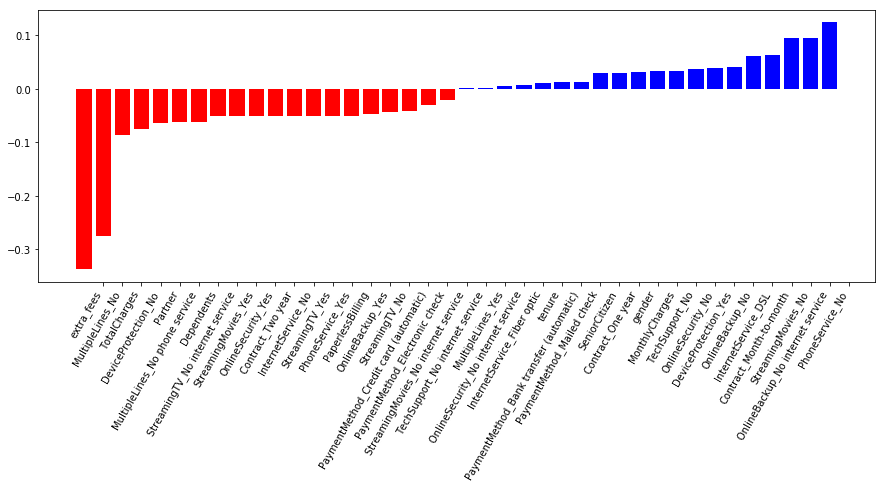

In [77]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()


final_model = LinearSVC(C=10)
final_model.fit(X,y)
names = list(df.columns[1:])
print(names)
names.remove('Churn')
plot_coefficients(final_model,names)

#### Customers with tenures > 1year (12)

In [ ]:
df_oneyear = df[df["tenure"]>12]
df_oneyear.shape
df_oneless = df[df["tenure"]<=12]
df_oneless.shape
#check how many of each churn class


#check how many of each churn class
print("Churned/Total all customers ", round(len(df[df["Churn"] == 1])/df.shape[0],2))
print("Churned/Total customers w. tenure > 12 ", round(len(df_oneyear[df_oneyear["Churn"] == 1])/df_oneyear.shape[0],2))
print("Churned/Total customers w. tenure <= 12 ", round(len(df_oneless[df_oneless["Churn"] == 1])/df_oneless.shape[0],2))
X_one = df_oneyear[df_oneyear.columns.difference(['Churn', 'customerID'])].values
y_one = df_oneyear["Churn"].values
scaler = StandardScaler()
X_one = scaler.fit_transform(X_one)

In [ ]:
final_model = LinearSVC()
final_model.fit(X_one,y_one)
names = list(df_oneyear.columns[1:])
print(names)
names.remove('Churn')
# plot_coefficients(final_model,names)

In [ ]:
final_model = SVC(kernel="linear",class_weight="balanced")
y_pred = cross_val_predict(final_model, X_one, y_one, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y_one))
print()
print(confusion_matrix(y_pred, y_one))
print()
print(classification_report(y_one,y_pred))

In [ ]:
df_oneless = df[df["tenure"]<=12]
df_oneless.shape
#check how many of each churn class
print("Churned/Total all customers ", len(df[df["Churn"] == 1])/df.shape[0])
print("Churned/Total customers w. tenure > 12 ", len(df_oneless[df_oneless["Churn"] == 1])/df_oneless.shape[0])
X_oneless = df_oneless[df_oneless.columns.difference(['Churn', 'customerID'])].values
y_oneless = df_oneless["Churn"].values
scaler = StandardScaler()
X_one = scaler.fit_transform(X_oneless)

In [ ]:
final_model =  SVC(C=1.0, kernel='rbf', 
               degree= 3, gamma=1.0, 
               coef0=0.0, shrinking=True,
               probability=True,tol=0.001,
               cache_size=200, class_weight=None,
               verbose=False,max_iter= -1,
               random_state=None)

y_pred = cross_val_predict(final_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

In [ ]:
plt.scatter(df.sort_values("extra_fees", axis=0, ascending=True)["tenure"], df.sort_values("extra_fees", axis=0, ascending=True)["extra_fees"], alpha=0.5)
plt.show()

In [ ]:
model =  SVC()

y_pred = cross_val_predict(model, X_new, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Optimal number of features : 23


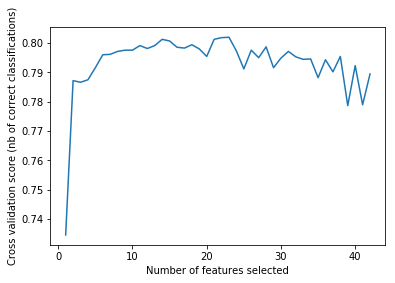

In [69]:
# Create the RFE object and compute a cross-validated score.
svc = LinearSVC(C=10)
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [70]:
#the best features are assigned to 1.
rankings = rfecv.ranking_


names = list(df.columns[1:])

names.remove('Churn')
print(names)
len(rankings)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'extr

42

In [71]:
features = list(zip(names, rankings))

In [72]:
toDrop = [x[0] for x in features if x[1] != 1]
print(len(toDrop))
toDrop.extend(["Churn","customerID"])


19


In [73]:
X = df[df.columns.difference(toDrop)].values
y = df["Churn"].values
print("FULL")
print(X.shape)
print(y.shape)
scaler = StandardScaler()
X = scaler.fit_transform(X)

FULL
(7043, 23)
(7043,)


In [74]:
final_model =LinearSVC(C=10)
y_pred = cross_val_predict(final_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Accuracy:  0.7963935822802783

[[4598  858]
 [ 576 1011]]

             precision    recall  f1-score   support

          0       0.84      0.89      0.87      5174
          1       0.64      0.54      0.59      1869

avg / total       0.79      0.80      0.79      7043



In [ ]:
df.describe()["extra_fees"]

In [83]:
 df[df.columns.difference(toDrop)].shape

(7043, 23)

In [78]:
len(toDrop)

21

In [87]:
final_model = SVC(C=8, gamma=0.001953125)
y_pred = cross_val_predict(final_model, X, y, cv=5)

print("Accuracy: ",accuracy_score(y_pred, y))
print()
print(confusion_matrix(y_pred, y))
print()
print(classification_report(y,y_pred))

Accuracy:  0.8043447394576175

[[4718  922]
 [ 456  947]]

             precision    recall  f1-score   support

          0       0.84      0.91      0.87      5174
          1       0.67      0.51      0.58      1869

avg / total       0.79      0.80      0.79      7043



In [86]:
opt_params_rbf = svc_param_selection(X, y, 3, 'rbf')
print(opt_params_rbf)

{'C': 8, 'gamma': 0.001953125}


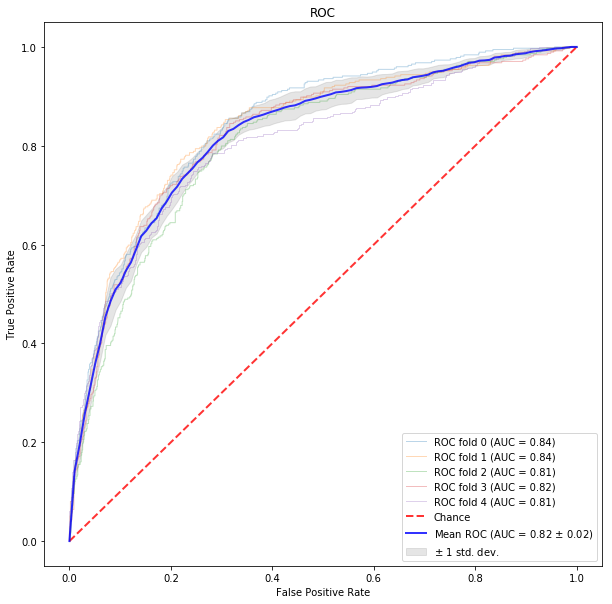

In [92]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = SVC(kernel="rbf",C=8, gamma=0.001953125, probability=True,random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()